# Generating Brown Dwarf Emission Spectra

This tutorial demonstrates how to compute the direct emission spectrum of a directly imaged object (brown dwarf or directly imaged exoplanet).

## A Basic T Dwarf Model

We'll make a simple cloud-free T dwarf model loosely on the retrieved parameters from Line+2015.

### System properties

For a directly observed object, we want to compute a model of the flux observed at Earth, $F_p$. We don't have to consider a star in this case, but we do have to provide the distance to the system.

In [1]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J
import numpy as np
from scipy.constants import parsec as pc

#***** Define planet / brown dwarf properties *****#

planet_name = 'GJ 570 D'  # Planet name used for plots, output files etc.

R_p = 1.1481664*R_J   # Planetary radius (m)
log_g = 4.76          # log_10 gravitational field of planet (cm/s^2)
d = 5.882*pc          # Distance to system (m)
d_err = 0.00311*pc    # Error in a priori system distance

# Create the planet object
planet = create_planet(planet_name, R_p, log_g = log_g, d = d, d_err = d_err)

# No star in this case
star = None

In [2]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Brown-Dwarf'         # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']
param_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3', 'HCN', 'Na', 'K']

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     object_type = 'directly_imaged', gravity_setting = 'free',
                     PT_profile = 'slope', scattering = False)

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'log_g' 'd' 'T_phot_PT' 'Delta_T_1' 'Delta_T_2' 'Delta_T_3'
 'Delta_T_4' 'Delta_T_5' 'Delta_T_6' 'Delta_T_7' 'log_H2O' 'log_CH4'
 'log_CO' 'log_CO2' 'log_NH3' 'log_HCN' 'log_Na' 'log_K']


Note that $d$ is the distance to the brown dwarf, which is typically a free parameter in retrievals. For this forward model we initialise the distance by providing it to the `create_planet` function above.

In [3]:
from POSEIDON.core import make_atmosphere

# Specify the pressure grid of the atmosphere
P_min = 1.0e-3    # 1 mbar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([900.0, 0, 100, 300, 200, 300, 400, 530])

log_X_params = np.array([[-3.45, -3.40, -7.53, -7.76, -4.64, -20.0, -5.50, -6.69]])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, 
                             log_X_params, log_g = log_g)

Let's see what our atmosphere looks like.

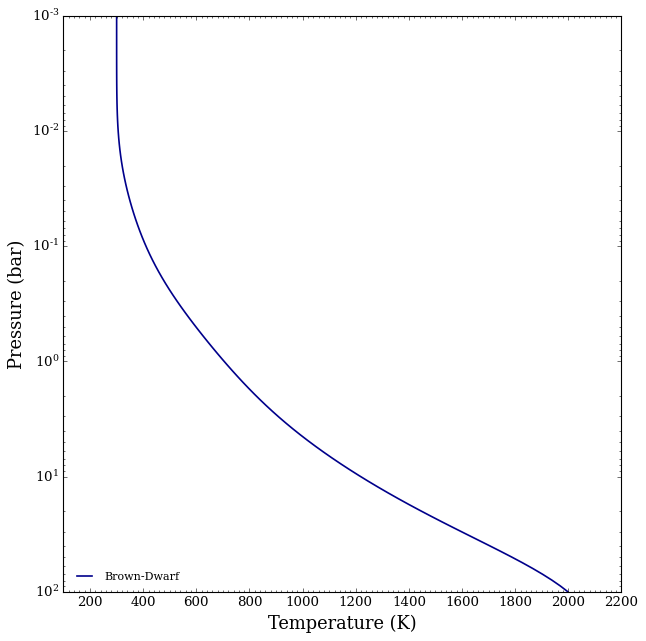

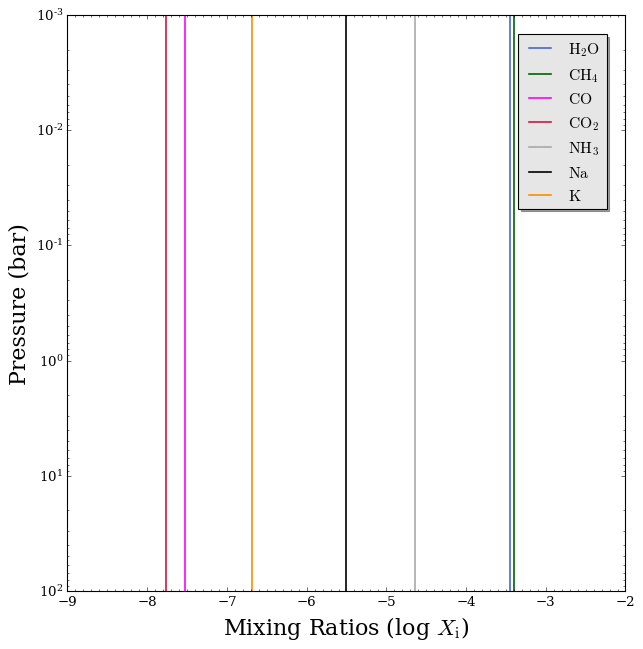

In [4]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model, atmosphere, log_P_max = 2.0)

fig_chem = plot_chem(planet, model, atmosphere, 
                     plot_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3', 'Na', 'K'],
                     log_X_min = -9, log_P_max = 2.0)

Pre-load opacities


In [5]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Wavelength grid *****#
 
wl_min = 0.4      # Minimum wavelength (um)
wl_max = 2.0      # Maximum wavelength (um)
R = 15000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 200     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2200    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -4.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO done
CO2 done
NH3 done
HCN done
Na done
K done
Opacity pre-interpolation complete.


### Compute Emission Spectrum

Now we can generate the emission spectrum of our brown dwarf.

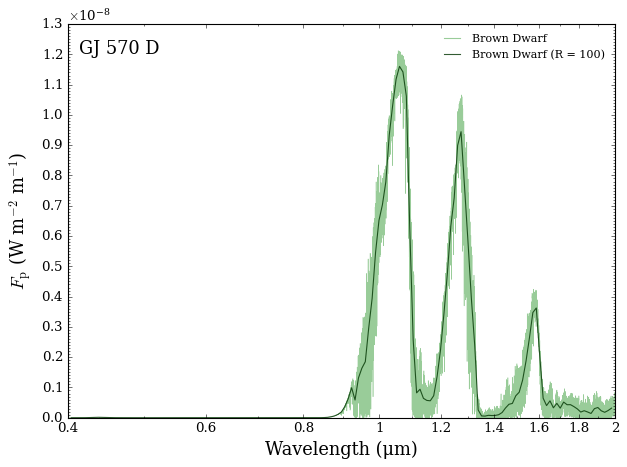

In [6]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate brown dwarf surface flux
Fp = compute_spectrum(planet, star, model, atmosphere, opac, wl, 
                      spectrum_type = 'direct_emission',   # <---- Remember to put spectrum_type = 'direct_emission' to get Fp
                      ) 

spectra = []   
spectra = plot_collection(Fp, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = True,
                        y_unit = 'Fp', spectra_labels = ['Brown Dwarf'],
                        legend_location = 'upper right', legend_box = False,
                        wl_axis = 'log', wl_min = 0.4, wl_max = 2.0,
                        )

## A Y-Dwarf with Scattering Clouds

To demonstrate the effect of thermal scattering, we define a forward model Y-dwarf with water ice aerosols in it.

Y dwarfs are the coldest class of brown dwarf, and can get cold enough to have substantial water clouds (atmosphere is similar temperature to a warm oven)

Water ice is a strong forward scatterer, which we should be familiar with here on Earth (it is why clouds are white!)

Since water ice is a strong forward scatterer, it will make a spectra brighter in certain wavelengths due to thermal emission being forward scattered instead of absorbed (or assumed lost to the beam).

In [7]:
#***** Define planet / brown dwarf properties *****#

planet_name = 'H$_2$O Ice Rich Y Dwarf'  # Planet name used for plots, output files etc.

# Parameters are consistent with WISE 0855-0714

R_p = 1.17*R_J        # Planetary radius (m)
log_g = 4.0           # log_10 gravitational field of planet (cm/s^2)
d = 5.882*pc          # Distance to system (m)
d_err = 0.00311*pc    # Error in a priori system distance

# Create the planet object
planet = create_planet(planet_name, R_p, log_g = log_g, d = d, d_err = d_err)

# No star in this case
star = None

We will make a simple direct maging model with slab Mie scattering aerosols. We define two models, one with scattering off (default setting) and one with it on.

IMPORTANT: As of 1.2, POSEIDON only supports one aerosol species for scattering and reflection. In the future, we hope to add in mutiple aerosol species, as is done in transmission and emission without scattering/reflection.

In [8]:
#***** Define model *****#

model_name = 'Scattering_direct_imaging'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']
param_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3', 'HCN']
aerosol_species = ['H2O']

# Create the model object
model_no_scat = define_model(model_name, bulk_species, param_species, 
                             object_type = 'directly_imaged', gravity_setting = 'free',
                             PT_profile = 'slope', 
                             cloud_model = 'Mie', cloud_type = 'slab',
                             aerosol_species = aerosol_species,
                             scattering = False)

model_scat = define_model(model_name, bulk_species, param_species, 
                          object_type = 'directly_imaged', gravity_setting = 'free',
                          PT_profile = 'slope', 
                          cloud_model = 'Mie', cloud_type = 'slab',
                          aerosol_species = aerosol_species,
                          scattering = True)

# Check the free parameters defining this model
print("Free parameters: " + str(model_no_scat['param_names']))

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
Free parameters: ['R_p_ref' 'log_g' 'd' 'T_phot_PT' 'Delta_T_1' 'Delta_T_2' 'Delta_T_3'
 'Delta_T_4' 'Delta_T_5' 'Delta_T_6' 'Delta_T_7' 'log_H2O' 'log_CH4'
 'log_CO' 'log_CO2' 'log_NH3' 'log_HCN' 'log_P_top_slab_H2O'
 'Delta_log_P_H2O' 'log_r_m_H2O' 'log_X_H2O']


In [9]:
# Specify the pressure grid of the atmosphere
P_min = 1.0e-3    # 1 mbar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

#***** Wavelength grid *****#
 
wl_min = 0.4      # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 10000    # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([900.0/2, 0, 100/2, 300/2, 200/2, 300, 400, 530])
log_X_params = np.array([[-3, -4, -5, -7, -4, -20.0,]])

# Cloud Params for slab
log_P_top_slab_H2O =  -3
Delta_log_P_H2O    =  5
log_r_m_H2O        =   1 # Corresponds to 10 um sized particles
log_X_H2O          =   -21

cloud_params = np.array([log_P_top_slab_H2O, Delta_log_P_H2O, log_r_m_H2O, log_X_H2O])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model_no_scat, P, P_ref, R_p_ref, PT_params, 
                             log_X_params, cloud_params, log_g = log_g)

Let's see what our atmosphere looks like.

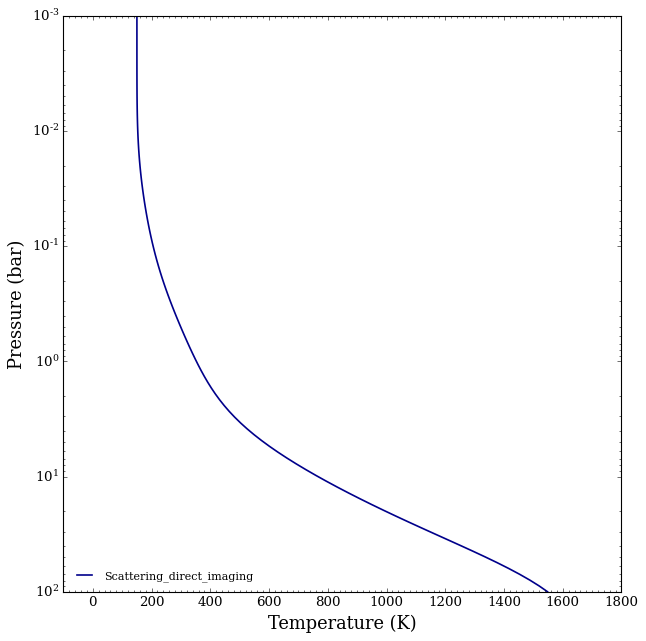

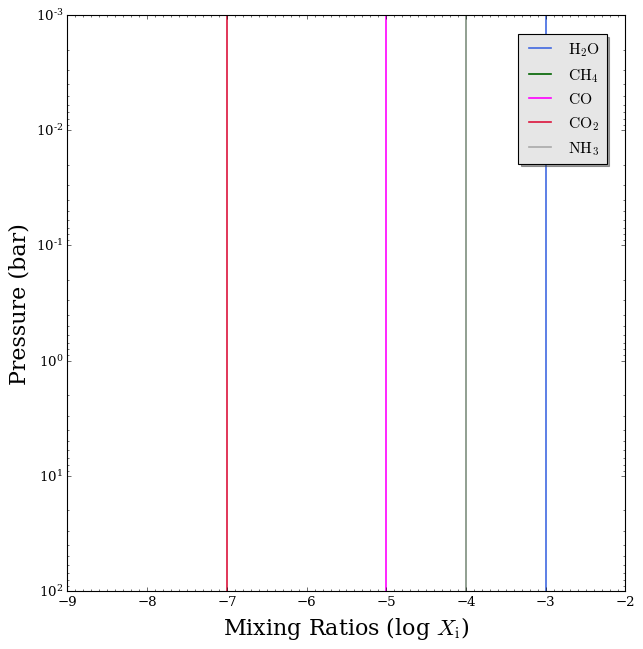

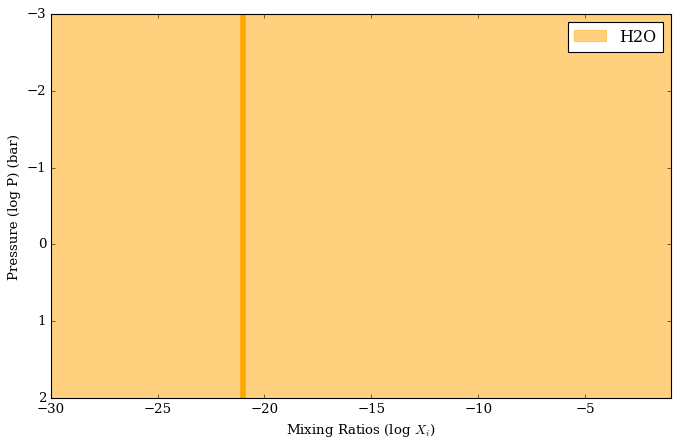

In [10]:
from POSEIDON.clouds import plot_clouds

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_no_scat, atmosphere, log_P_max = 2.0)


fig_chem = plot_chem(planet, model_no_scat, atmosphere, 
                     plot_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3'],
                     log_X_min = -9, log_P_max = 2.0)

plot_clouds(planet,model_scat,atmosphere)

Now we'll load the opacities to calculate the spectrum of this Y dwarf.


In [11]:
#***** Wavelength grid *****#
 
wl_min = 0.4     # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 10000        # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -4.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_no_scat, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO done
CO2 done
NH3 done
HCN done
Opacity pre-interpolation complete.


### Compute Y-dwarf Emission Spectrum

Now we can generate the emission spectrum of our brown dwarf.

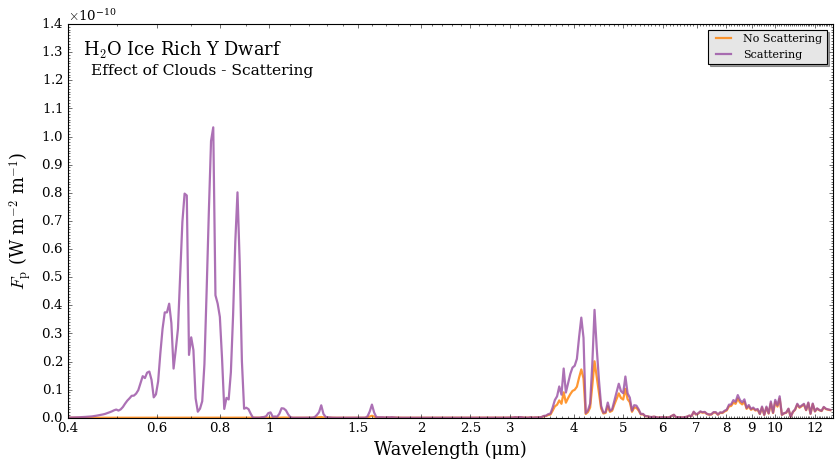

In [12]:
# Generate brown dwarf surface flux
Fp_no_scat = compute_spectrum(planet, star, model_no_scat, atmosphere, opac, wl, 
                              spectrum_type = 'direct_emission', save_spectrum = True)
Fp_scat = compute_spectrum(planet, star, model_scat, atmosphere, opac, wl, 
                           spectrum_type = 'direct_emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'Fp', spectra_labels = ['No Scattering', 'Scattering'],
                        legend_location = 'upper right', wl_axis = 'log', 
                        colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title,
                        figure_shape = 'wide')

Wow! You can really the effect of forward scattering in the shorter wavelengths, where thermal emission is being forward scattered by the water ice. 

### Investigating Scattering Properties 

Let's dig a little deeper into the Mie scattering properties of our Y dwarf.

Reading in database for aerosol cross sections...


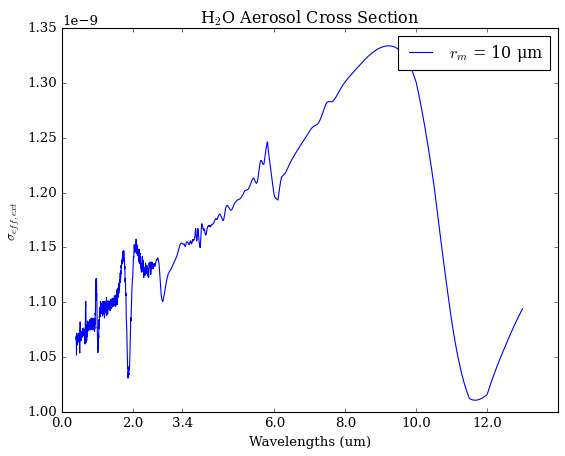

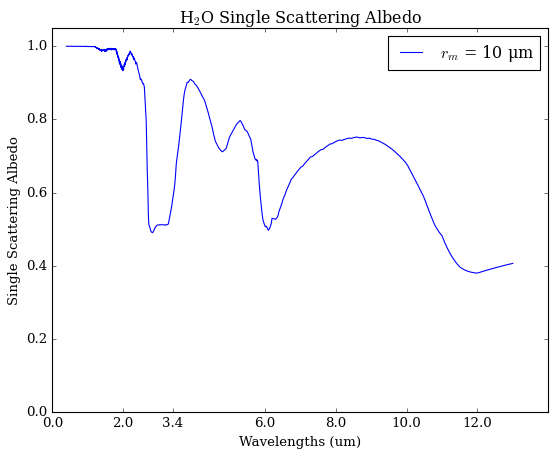

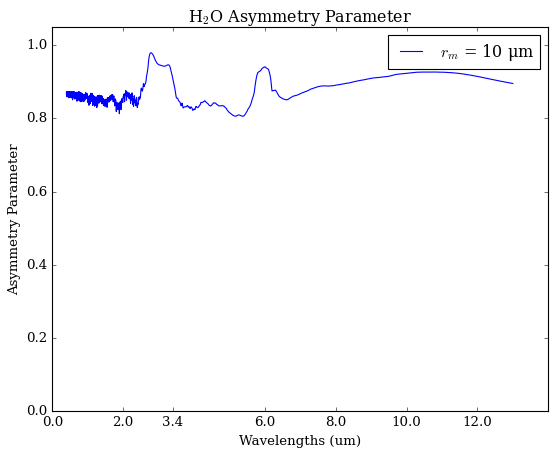

In [13]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'H2O'

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Test to see if the cross sections come out with SiO2 particle, 0.01 um sized
r_m = 10

# This formula loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

label = '$r_m$ = ' + str(r_m) + ' μm'
title = 'H$_2$O Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.xticks((0,2,3.4,6,8,10,12))
plt.show()

title = 'H$_2$O Single Scattering Albedo'

plt.plot(wl,eff_w, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Single Scattering Albedo')
plt.xticks((0,2,3.4,6,8,10,12))
plt.ylim((0,1.05))
plt.show()

title = 'H$_2$O Asymmetry Parameter'

plt.plot(wl,eff_g, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Asymmetry Parameter')
plt.xticks((0,2,3.4,6,8,10,12))
plt.ylim((0,1.05))
plt.show()

We see that large water ice particles have a single scattering albedo near one in short wavelengths, meaning that the aerosol will preferentially scatter instead of absorb. They also have an asymmetry parameter near 1, which means that the light is being forward scattered (in lieu of being symmetrically scattered, like in the Rayleigh case).